In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.preprocessors import FeatureEngineer

%matplotlib inline

/home/ubuntu/anaconda3/envs/sh_rl_p37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
stock_lst={'현대건설':'000720','KB금융':'105560','현대로템':'064350',
           '강원랜드':'035250','현대모비스':'012330','포스코인터내셔널':'047050',
           '현대차':'005380','한국가스공사':'036460','LG전자':'066570','SK하이닉스':'000660',
           'POSCO홀딩스':'005490','KT':'030200','LG화학':'051910', # Stock
           'KODEX인버스':'114800','KODEX200선물인버스2x':'252670'} # ETF
'''

df=pd.read_csv('./RL_project_STAR/original_df_v2.csv',index_col=0)

technical_index=['boll_low','boll_mid','boll_high','macd','macd_sig','macd_osc','rsi','rsi_sig','fast_k','slow_k','slow_d']

fe = FeatureEngineer(
                    use_technical_indicator=False,
                    #tech_indicator_list = technical_index,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed

Successfully added turbulence index


,date,tic,open,high,low,close,volume,day,boll_low,boll_mid,boll_high,macd,macd_sig,macd_osc,rsi,rsi_sig,fast_k,slow_k,slow_d,turbulence
0,2016-11-04,660,41150,41400,40850,41200,2600930,1,39686.704823,41362.50,43038.295177,229.674599,328.373093,-98.698494,53.0,57.000000,49.473684,47.719298,51.111111,0.000000
1,2016-11-04,720,40476,40476,39405,39795,335401,1,38898.584395,40869.75,42840.915605,264.619248,578.287012,-313.667764,45.0,46.888889,25.789362,25.097125,21.721539,0.000000
2,2016-11-04,5380,136500,137000,135500,136000,345493,1,130249.020424,135975.00,141700.979576,-25.989197,-406.923421,380.934225,40.0,44.666667,45.000000,58.333333,74.444444,0.000000
3,2016-11-04,5490,238000,238000,234500,238000,168319,1,225828.627267,237725.00,249621.372733,1956.750670,2788.289373,-831.538703,46.0,47.222222,35.897436,34.719435,37.032082,0.000000
4,2016-11-04,12330,267000,268000,264000,265000,116780,1,254734.810681,266425.00,278115.189319,-3123.674594,-4258.974498,1135.299904,37.0,34.666667,46.666667,55.555556,61.665620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22315,2022-11-22,64350,29000,29200,28450,28850,4387215,1488,22275.010214,25560.00,28844.989786,787.038600,267.936900,519.101699,67.0,59.777778,86.486486,80.329025,78.817429,19.302335
22316,2022-11-22,66570,90300,90700,89100,89500,392751,1488,76599.562933,88565.00,100530.437067,2259.793263,2293.833276,-34.040013,53.0,63.333333,47.752809,54.087002,62.529754,19.302335
22317,2022-11-22,105560,49800,50100,49400,49800,887540,1488,45877.840643,48357.50,50837.159357,726.006333,604.636115,121.370217,60.0,59.777778,91.891892,83.783784,77.477477,19.302335
22318,2022-11-22,114800,4870,4900,4845,4900,22427910,1488,4627.685988,4939.75,5251.814012,-93.073486,-93.460347,0.386860,100.0,100.000000,43.956044,34.517964,26.688756,19.302335


In [4]:
# 단순 보유 모델

balance=10000000 #처음 잔고
start_date='2022-01-03' #풀매수 날짜

processed_1=processed.pivot(index='date', columns='tic', values='close') #종가 정보만 가져옴
initial=pd.DataFrame(processed_1.loc[start_date]) #매수일 종가
values=pd.DataFrame(processed_1.loc[start_date:]) #trade 환경
qty=balance//initial.sum() #전종목 몇주씩 매수 가능한지
initial_value=initial.sum()*qty #최초 매수 시 평가액
left_balance=balance-initial_value[0] #매매 후 남은 현금

<AxesSubplot:xlabel='date'>

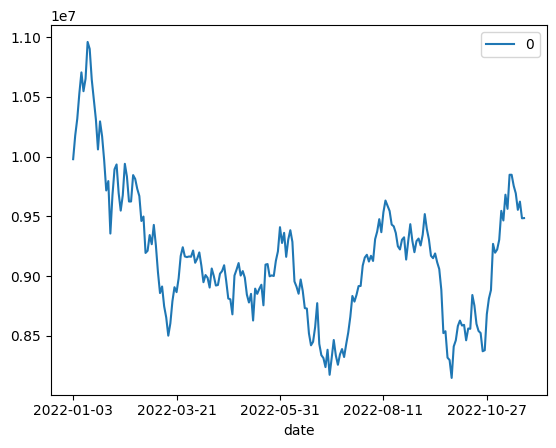

In [5]:
simpletrading=pd.DataFrame(values.sum(axis=1)*int(qty)+left_balance) #평가액 dataframe
simpletrading.loc[start_date][0]=initial_value*(1-0.0023)+left_balance #매수 시 거래세 반영

simpletrading.plot()

In [6]:
# 이동평균선 모델

'''
policy:
    5일선이 20일선 추월 → 1주 매수

    5일선이 60일선도 추월 → 남은 현금으로 전부 매수

    20일선이 5일선 추월 → 1주 매도

    60일선도 5일선 추월 → 전량 매도

    매수보다 매도를 먼저 처리함 -> 매도 할 주식이 있다면 매도 후 현금이 생기고, 만약 그 날 매수할 주식이 있다면 매수할 수 있음.

    매수할 주식이 여러개라면 현금이 가능한 선에서 공평하게 매수

특징:
    실험에 사용된 기간동안 주가가 하락세를 유지하여 이평선간 추월이 잘 일어나지 않았음. 즉, 매매 횟수가 적음.
    일반 투자자들 뿐만 아니라 일부 전문 투자자들도 사용하는 방법이지만 이평선만을 고려하는 방법은 효과적인 방법이 아니라고 알려져 있음.
    여기서도 낮은 수익률을 보임
'''

import random
balance = 10000000
start_date='2022-01-03'
tax = 1 - 0.0023
start_index = processed[processed.date == start_date].index[0]

asset_state = {"cash" : balance}
for i in processed.tic.unique():
  price = processed[processed.tic == i].close.values.tolist()
  globals()["moving_ave60_{}".format(i)] = []
  globals()["moving_ave20_{}".format(i)] = []
  globals()["moving_ave5_{}".format(i)] = []
  globals()["delta_60_5_{}".format(i)] = []
  globals()["delta_20_5_{}".format(i)] = []
  asset_state[i] = 0
  # 매매 시작 전날의 이평선부터 고려
  count = 0
  for j in range(int((start_index)/15-1),int(len(processed)/15)):
    globals()["moving_ave60_{}".format(i)].append(sum(price[j-59:j])/60)
    globals()["moving_ave20_{}".format(i)].append(sum(price[j-19:j])/20)
    globals()["moving_ave5_{}".format(i)].append(sum(price[j-4:j])/5)
    globals()["delta_60_5_{}".format(i)].append(globals()["moving_ave60_{}".format(i)][count] - globals()["moving_ave5_{}".format(i)][count])
    globals()["delta_20_5_{}".format(i)].append(globals()["moving_ave20_{}".format(i)][count] - globals()["moving_ave5_{}".format(i)][count])
    count += 1


asset_value_arr = []
price_now = dict()
for i in range(int((start_index)/15)-int((start_index)/15),int(len(processed)/15)-int((start_index)/15)):
  trade_or_not_20 = []
  trade_or_not_60 = []
  price_to_buy_20 = 0
  price_to_buy_60 = 0
  # 매도. 매도먼저 하기 때문에 같은 타임스텝에서 돈생겼을때 다시 매수할수 있음
  for j in processed.tic.unique():
    price_now[j] = processed[processed.tic == j].close.values.tolist()[i]
    if globals()["delta_20_5_{}".format(j)][i-1] <= 0 and globals()["delta_20_5_{}".format(j)][i] > 0 and asset_state[j] > 0:
      asset_state["cash"] += price_now[j]*tax
      asset_state[j] -= 1
    if globals()["delta_60_5_{}".format(j)][i-1] <= 0 and globals()["delta_60_5_{}".format(j)][i] > 0 and asset_state[j] > 0:
      asset_state["cash"] += price_now[j]*asset_state[j]*tax
      asset_state[j] = 0
    if globals()["delta_20_5_{}".format(j)][i-1] >= 0 and globals()["delta_20_5_{}".format(j)][i] < 0:
      trade_or_not_20.append(j)
      price_to_buy_20 += price_now[j]
    if globals()["delta_60_5_{}".format(j)][i-1] >= 0 and globals()["delta_60_5_{}".format(j)][i] < 0:
      trade_or_not_60.append(j)
      price_to_buy_60 += price_now[j]
  
  # 매수. 뭐부터 살지는 애매하지만 20이평선 돌파를 우선해서 공평하게 1주씩 다 사는거로 함. 돈이 남으면 또 공평하게 60이평선 돌파한 종목을 샀음
  if trade_or_not_20:
    if price_to_buy_20 > asset_state["cash"]: # 20이평선 돌파주를 1주씩 살 잔고가 충분하지 않을 때. 랜덤으로 삼
      for key in trade_or_not_20:
        rc = random.choice(trade_or_not_20)
        if price_now[rc] <= asset_state["cash"]:
          asset_state["cash"] -= price_now[rc]
          asset_state[rc] += 1
          trade_or_not_20.remove(rc) 
    else: # 잔고가 충분할 때. 20이평선 1주씩 다 삼
      asset_state["cash"] -= price_to_buy_20
      for key in trade_or_not_20:
        asset_state[key] += 1

  if trade_or_not_60:
    if price_to_buy_60 <= asset_state["cash"]:  # 60이평선 돌파주를 1주씩 살 돈이 충분할때. 될수있는데까지 다 삼
      for key in trade_or_not_60:
        asset_state[key] += asset_state["cash"]//price_to_buy_60
      asset_state["cash"] = asset_state["cash"]%price_to_buy_60

    for key in trade_or_not_60: # 공평하게 못사면 랜덤으로 돌림
      rc = random.choice(trade_or_not_60)
      if price_now[rc] <= asset_state["cash"]:
        asset_state["cash"] -= price_now[rc]
        asset_state[rc] += 1
        trade_or_not_60.remove(rc)
  
  asset_value = 0
  for key in asset_state.keys():
    if key == "cash":
      asset_value += asset_state["cash"]
    else:
      asset_value += asset_state[key]*price_now[key]*tax
  asset_value_arr.append(asset_value)

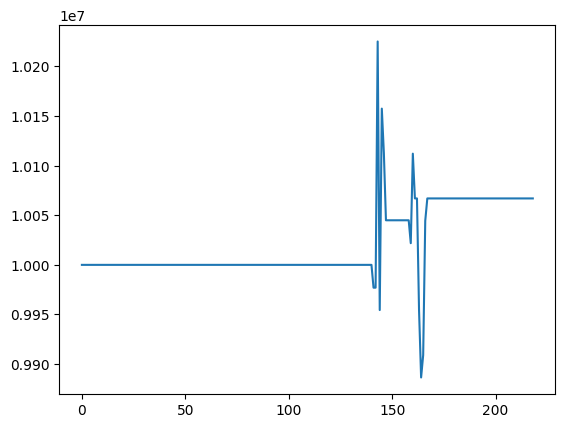

66935.24500000104


In [7]:
# 자산가격 그래프
plt.plot(asset_value_arr)
plt.show()

# 수익
print(asset_value_arr[len(asset_value_arr)-1]-balance)